In [1]:
import os
import numpy as np
from matplotlib import pyplot
from scipy import optimize
from scipy.io import loadmat
%matplotlib inline

In [2]:
data = loadmat('ex5data1.mat')
X, y = data['X'],data['y']
Xtest,ytest = data['Xtest'],data['ytest']
Xval,yval = data['Xval'],data['yval']
m = y.size

Text(0, 0.5, 'Water flowing out of the dam (y)')

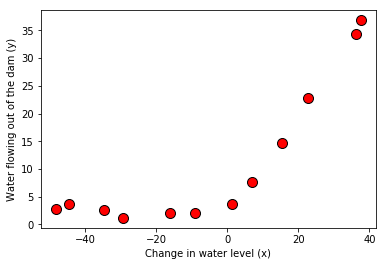

In [3]:
pyplot.plot(X,y,'ro',ms=10,mec='k',mew=1)
pyplot.xlabel('Change in water level (x)')
pyplot.ylabel('Water flowing out of the dam (y)')

In [4]:
def linearRegCostFunction(X,y,theta,lambda_=0.0):
    m = y.size
    J = 0

    grad = np.zeros((X.shape[1]+1,1))
    theta=theta.reshape(X.shape[1]+1,1)
    X = np.concatenate([np.ones((X.shape[0],1)),X],axis=1)    
    prediction = X.dot(theta)

    temp = theta
    temp[0] = 0
    J = 1.0/(2.0*m)*(np.sum((prediction-y)**2))+lambda_/(2.0*m)*(np.sum(temp**2))
#     J = 1.0/(2.0*m)*(np.sum((prediction-y)**2))+lambda_/2.0*(np.sum(temp**2))
    
    grad = 1.0/m*X.T.dot(prediction-y)+lambda_/m*temp
    
    return J, grad

In [5]:
theta = np.ones(2)
J, grad = linearRegCostFunction(X,y,theta,0)
J, grad

(303.9515255535976, array([[-15.30301567],
        [598.16741084]]))

In [6]:
def trainLinearReg(objfunc, X, y, lambda_=0, maxiter = 200):
    itheta=np.ones((X.shape[1]+1,1))
    costgradF = lambda t : objfunc(X,y,t,lambda_)
    res = optimize.minimize(costgradF,itheta,jac=True,method='tnc',options={'maxiter':maxiter})
    
    return res.x

In [7]:
optheta = trainLinearReg(linearRegCostFunction,X,y,lambda_=0,maxiter=200)
optheta

array([0.        , 0.30304721])

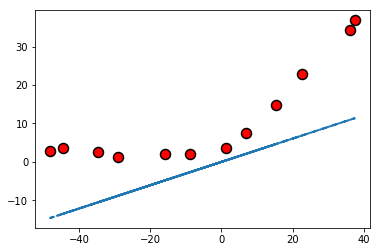

In [8]:
pyplot.plot(X,y,'ro',ms=10,mec='k',mew=1.5)
pyplot.plot(X,np.dot(np.concatenate([np.ones((12,1)),X],axis=1),optheta),'--',lw=2)

In [9]:
def LearinngCurve(X, y , Xval, yval, lambda_=0):
    m = y.size
    error_train = np.zeros(m)
    error_val = np.zeros(m)
    # X=np.concatenate([np.ones((m,1)),X], axis=1)
    
    for i in range(m):
        temp1=X[:(i+1),:]
        temp2=y[:(i+1),:]
        theta=trainLinearReg(linearRegCostFunction,temp1,temp2,lambda_=0,maxiter=200)
        Jt, gradt = linearRegCostFunction(temp1,temp2,theta,lambda_=0)
        Jv, gradv = linearRegCostFunction(Xval,yval,theta,lambda_=0)
        error_train[i]=Jt
        error_val[i]=Jv
        
    
    
    return error_train, error_val

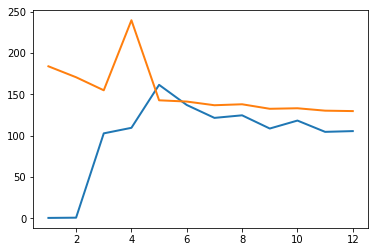

In [10]:
error_train, error_val = LearinngCurve(X,y,Xval,yval,lambda_=0)
pyplot.plot(np.arange(1,m+1), error_train,np.arange(1,m+1),error_val, lw=2)


In [11]:
def polyFeatures(X,p):
    X_poly = np.zeros((X.shape[0],p))
    
    for i in range(p):
        u=X**(i+1)
        u=u.reshape(1,X.shape[0])
        X_poly[:,i] = u
    
    return X_poly

In [12]:
def featureNormalize(X):
    mu = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    return X-mu/std, mu, std

In [13]:
p=8
X_poly=polyFeatures(X,p)
X_poly.shape

(12, 8)

In [14]:
lambda_ = 100
theta = trainLinearReg(linearRegCostFunction,X_poly, y, lambda_=lambda_, maxiter=55)

In [15]:
X_poly, mu_train, std_train = featureNormalize(X_poly)
#X_poly = np.concatenate([np.ones((X_poly.shape[0],1)),X_poly],axis=1)

X_poly_test = polyFeatures(Xtest, p)
X_poly_test = X_poly_test - mu_train / std_train
#X_poly_test = np.concatenate([np.ones((X_poly_test.shape[0],1)),X_poly_test],axis=1)

X_poly_val = polyFeatures(Xval, p)
X_poly_val = X_poly_val - mu_train / std_train
#X_poly_val = np.concatenate([np.ones((X_poly_val.shape[0],1)),X_poly_val],axis=1)

In [16]:
def plotfit(polyFeatures, min_x, max_x, mu, sigma, theta, p ):
    x = np.arange(min_x - 15, max_x + 25, 0.05 ).reshape(-1,1)
    X_poly = polyFeatures(x,p)
    X_poly = X_poly - mu_train / std_train
    
    X_poly = np.concatenate([np.ones((x.shape[0],1)),X_poly],axis=1)
    
    pyplot.plot(x,np.dot(X_poly,theta), '--',lw=2)

(-20, 50)

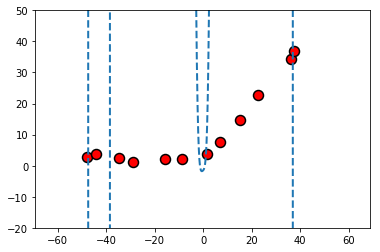

In [17]:
pyplot.plot(X,y,'ro',ms=10,mew=1.5, mec='k')
plotfit(polyFeatures, np.min(X), np.max(X), mu_train, std_train, theta, p)
pyplot.ylim([-20,50])

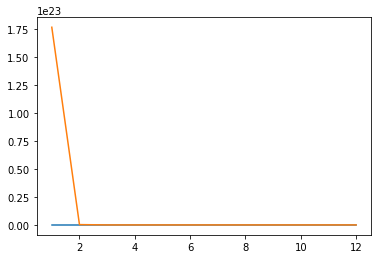

In [21]:
pyplot.figure()
error_train, error_val = LearinngCurve(X_poly, y, X_poly_val,yval,lambda_)
pyplot.plot(np.arange(1,1+m),error_train, np.arange(1,1+m), error_val)
pyplot.axis([0,13,0,100])

In [28]:
def validationCurve(X, y, Xval, yval):
    lambda_vec = [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]
    error_train = []
    error_val = []
    latheta = np.zeros(X.shape[1]+1)
    
    for i in lambda_vec:
        latheta=trainLinearReg(linearRegCostFunction,X,y,lambda_=i,maxiter=200)
        Jt, gradt = linearRegCostFunction(X,y,latheta,lambda_=i)
        Jv, gradv = linearRegCostFunction(Xval,yval,latheta,lambda_=i)
        error_train.append(Jt)
        error_val.append(Jv)
    
    
    return lambda_vec, error_train, error_val

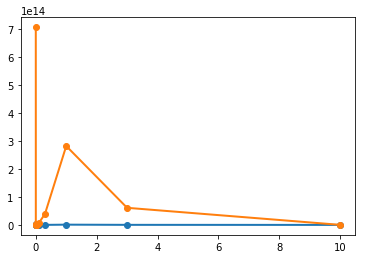

In [29]:
lambda_vec, error_train, error_val = validationCurve(X_poly, y, X_poly_val, yval)

pyplot.plot(lambda_vec, error_train, '-o', lambda_vec, error_val, '-o', lw=2)